# **NLP Sentiment Analysis on Amazon Cell Phone Reviews**

#### Amazon Cell Phone Reviews contain 82,815 customer reviews from 2004 to Sep 2019. Data size is about 28 M. Most popular brands are Samsung and Apple, with the percentage of 50% and 13% respectively.  About 96% cell Phones sold by carries are renewed or refurbished models. Among all brands Xiaomi has the highest rating. Each review is for an item with brand name and a rating ranged from 1 to 5. So the dataset is a perfect candidate for NLP sentiment analysis. In this project I will implement CNN/LSTM/GRU neural neworks for the sentiment analysis on the reviews.

## **Part II. CNN/GRU Neural Networks for Sentiment Analysis**

### **Load Preprocessed Data from Google Mount Drive** 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
path='/content/drive/My Drive/Data Sets/'
reviews = pd.read_csv(path+"reviews.csv")

In [0]:
reviews.clean_text=reviews.clean_text.astype(str)

### **Import sklearn, keras models, layers, etc.** 

In [4]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from keras import backend as K

from keras.preprocessing import text, sequence
from keras import optimizers
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, Conv1D, GRU, LSTM, MaxPooling1D, GlobalMaxPool1D
from keras.layers.wrappers import Bidirectional
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import gc



Using TensorFlow backend.


### **Using Glove.6B 200d Word Embedding**

In [0]:
X=reviews['clean_text']
y=reviews['class']

In [6]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(categories='auto',sparse=False)
ohe.fit(y.values.reshape(-1,1))
max_len=200
max_num_words=20000
tokenizer = text.Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)
X = sequence.pad_sequences(X, maxlen = max_len).astype(np.int32)
y = ohe.transform(y.values.reshape(-1,1)).astype(np.uint8)

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=10)
del X, y
gc.collect()

0

In [0]:
f= open('/content/drive/My Drive/Data Sets/glove.6B.200d.txt', 'r', encoding='utf-8')
embeddings_index={}
for line in f:
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except ValueError:
        pass
f.close()

word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, 200))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### **Bidirectional GRU/Unidirectional GRU Neural Networks**

#### The model trained for total reviews. Train accuracy is 82.2%, test accuracy is 84.1%. The data categories 3 classes: Positive (rating 4 and 5), neutral (rating 3) and negative (rating 1 and 2) reviews. The negative reviews are larger than positive reviews, distributed in a narrow range from 0 to 0.2; However, the neutral reviews cover whole range from 0 to 1, and tend to more negative side; positive reviews also have a tail to negative side. This means that even the customer rating is 3, the review words are more negative; and positive rating also includes negative words. 

In [8]:
nlabels=3

model = Sequential()
model.add(Embedding(len(word_index)+1,
                           200,
                           weights=[embedding_matrix],
                           input_length=max_len,
                           trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(GRU(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
model.add(GRU(128, dropout=0.3, recurrent_dropout=0.3))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.8))

model.add(layers.Dense(nlabels, activation='softmax')) #'sigmoid'
model.compile(loss='categorical_crossentropy',
                optimizer='adam', 
                metrics=['acc'])
model.summary()

batch=512
epoch=5

history = model.fit(xtrain, ytrain,
                    validation_split=0.2,
                    epochs=epoch,
                    batch_size=batch,
                   verbose=1)
score, acc = model.evaluate(xtest, ytest,
                            batch_size=batch)
model.save('gru_model.h5')













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 200)          9112400   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 200)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 256)          252672    
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               147840    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0   

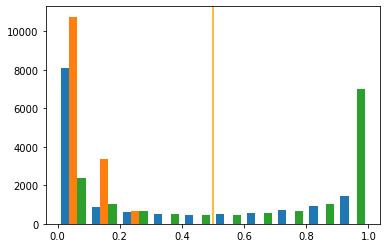

In [9]:
y_hat = model.predict_proba(xtest)
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

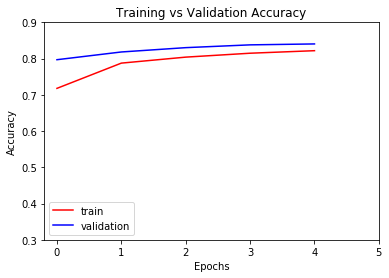

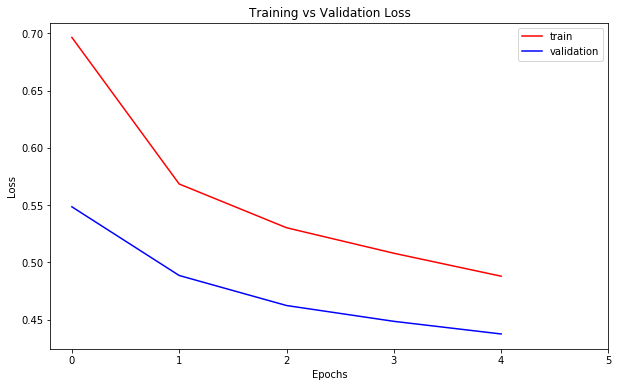

In [10]:
plt.plot(history.history['acc'], color='red')
plt.plot(history.history['val_acc'], color='blue')
plt.xticks(np.arange(0, epoch + 1))
plt.yticks(np.arange(0.3, 1, 0.1))
plt.rcParams['figure.figsize'] = (10, 6)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend(['train','validation'])
plt.show()

plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='blue')
plt.xticks(np.arange(0, epoch + 1))
plt.rcParams['figure.figsize'] = (5, 3)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend(['train','validation'])
plt.show()

### **CNN/Bi-GRU Model for Total Reviews**

### The model is a 1D CNN layer plus a Bidirectional GRU layer. The train time reduced about 60%. The result is similar to the first model, however, the train accuracy increased to 88.9% (+6.7%), test accuracy increased to 89.6% (+5.5%). The main reason of accuracy improvement is due to using Binary_Crossentropy as cost function. This can be understand that with pretrained Glove word embeddings, the review words are ranged from negative to positive, so the binary_crossentropy is better than categorical_crossentropy.

In [11]:
nlabels=3

model = Sequential()
model.add(Embedding(len(word_index)+1,
                           200,
                           weights=[embedding_matrix],
                           input_length=max_len,
                           trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(GRU(128, dropout=0.3, recurrent_dropout=0.3)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.8))

model.add(layers.Dense(nlabels, activation='softmax')) #'sigmoid'
model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc'])
model.summary()

batch=512
epoch=5

history = model.fit(xtrain, ytrain,
                    validation_split=0.2,
                    epochs=epoch,
                    batch_size=batch,
                   verbose=1)
                  
score, acc = model.evaluate(xtest, ytest,
                            batch_size=batch)
model.save('cnn_gru_model.h5')




Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 200)          9112400   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 200, 200)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 196, 128)          128128    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 128)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               197376    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)             

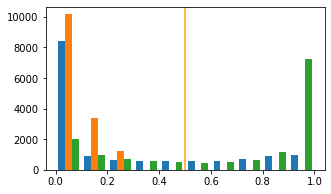

In [12]:
y_hat = model.predict_proba(xtest)
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

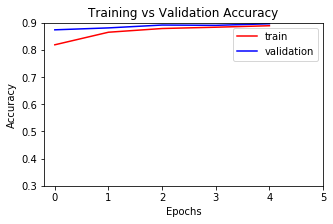

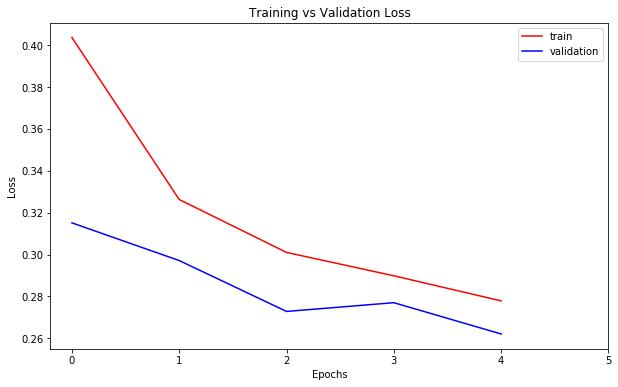

In [13]:
plt.plot(history.history['acc'], color='red')
plt.plot(history.history['val_acc'], color='blue')
plt.xticks(np.arange(0, epoch + 1))
plt.yticks(np.arange(0.3, 1, 0.1))
plt.rcParams['figure.figsize'] = (10, 6)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend(['train','validation'])
plt.show()

plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='blue')
plt.xticks(np.arange(0, epoch + 1))
plt.rcParams['figure.figsize'] = (5, 3)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend(['train','validation'])
plt.show()

### **Train Samsung Reviews with CNN/GRU**

#### About the 50% of reviews are from Samsung cell phones, so the result is similar to total reviews. Neutral class is more negative and has a tail to positive; positive class has a tail to negative. The train has no sign of overfitting. 

In [0]:
samsung = reviews[reviews["brand"]=="Samsung"].sort_values(by=["date"], ascending=False)

In [15]:
samsung.shape

(37526, 20)

In [0]:
X=samsung['clean_text']
y=samsung['class']

In [20]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(categories='auto',sparse=False)
ohe.fit(y.values.reshape(-1,1))
max_len=200
max_num_words=20000
tokenizer = text.Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)
X = sequence.pad_sequences(X, maxlen = 200).astype(np.int32)
y = ohe.transform(y.values.reshape(-1,1)).astype(np.uint8)

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=10)
del X, y
gc.collect()

0

In [21]:
nlabels=3

model = Sequential()
model.add(layers.Embedding(len(word_index)+1,
                           200,
                           weights=[embedding_matrix],
                           input_length=max_len,
                           trainable=False))
model.add(layers.SpatialDropout1D(0.3))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(GRU(128, dropout=0.3, recurrent_dropout=0.3)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.8))

model.add(layers.Dense(nlabels, activation='softmax')) #'sigmoid'
model.compile(loss='binary_crossentropy',
                optimizer='adam', 
                metrics=['acc'])
model.summary()

batch=512
epoch=8

history = model.fit(xtrain, ytrain,
                    validation_split=0.2,
                    epochs=epoch,
                    batch_size=batch,
                   verbose=1)
score, acc = model.evaluate(xtest, ytest,
                            batch_size=batch)
model.save('samsung_model.h5')



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 200)          9112400   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 200, 200)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 196, 128)          128128    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 98, 128)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               197376    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

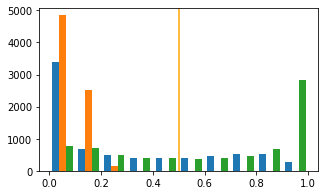

In [22]:
y_hat = model.predict_proba(xtest)
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

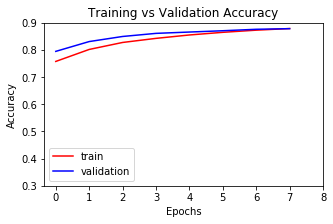

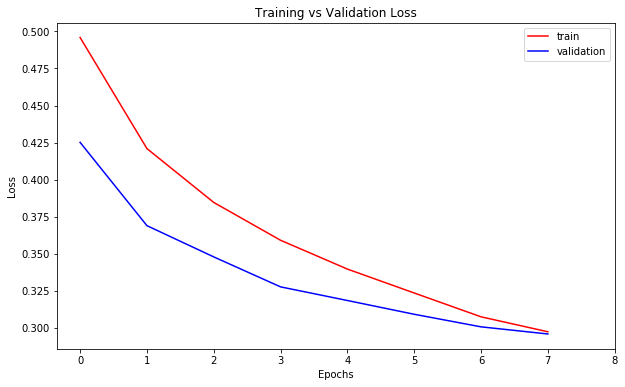

In [23]:
plt.plot(history.history['acc'], color='red')
plt.plot(history.history['val_acc'], color='blue')
plt.xticks(np.arange(0, epoch + 1))
plt.yticks(np.arange(0.3, 1, 0.1))
plt.rcParams['figure.figsize'] = (10, 6)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend(['train','validation'])
plt.show()

plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='blue')
plt.xticks(np.arange(0, epoch + 1))
plt.rcParams['figure.figsize'] = (10, 6)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend(['train','validation'])
plt.show()

### **Train Apple Reviews with CNN/GRU**

#### The Apple reviews trainng result is similar to Samsung, no surprise. 

In [0]:
apple = reviews[reviews["brand"]=="Apple"].sort_values(by=["date"], ascending=False)

In [37]:
apple.shape

(10481, 20)

In [0]:
X=apple['clean_text']
y=apple['class']

In [39]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(categories='auto',sparse=False)
ohe.fit(y.values.reshape(-1,1))
max_len=200
max_num_words=5000
tokenizer = text.Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)
X = sequence.pad_sequences(X, maxlen = 200).astype(np.int32)
y = ohe.transform(y.values.reshape(-1,1)).astype(np.uint8)

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=10)
del X, y
gc.collect()

10208

In [40]:
nlabels=3

model = Sequential()
model.add(layers.Embedding(len(word_index)+1,
                           200,
                           weights=[embedding_matrix],
                           input_length=max_len,
                           trainable=False))
model.add(layers.SpatialDropout1D(0.3))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(GRU(128, dropout=0.3, recurrent_dropout=0.3)))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.8))

model.add(layers.Dense(nlabels, activation='softmax')) #'sigmoid'
model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc'])
model.summary()

batch=512
epoch=10

history = model.fit(xtrain, ytrain,
                    validation_split=0.2,
                    epochs=epoch,
                    batch_size=batch,
                   verbose=1)
                   
score, acc = model.evaluate(xtest, ytest,
                            batch_size=batch)
model.save('apple_model.h5')



Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 200)          9112400   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 200, 200)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 196, 128)          128128    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 98, 128)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 256)               197376    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)              

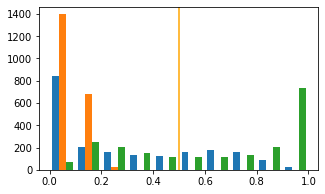

In [41]:
y_hat = model.predict_proba(xtest)
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

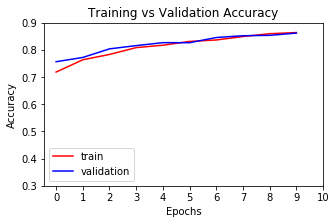

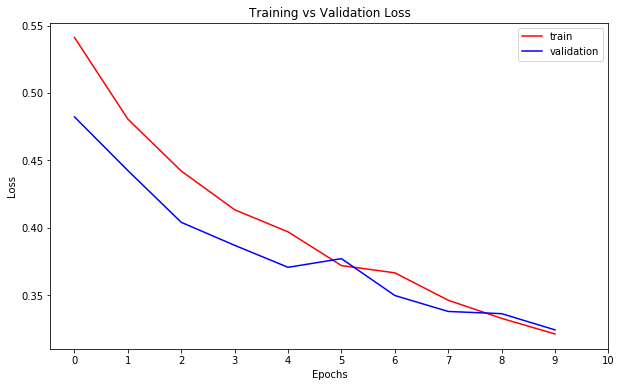

In [42]:
plt.plot(history.history['acc'], color='red')
plt.plot(history.history['val_acc'], color='blue')
plt.xticks(np.arange(0, epoch + 1))
plt.yticks(np.arange(0.3, 1, 0.1))
plt.rcParams['figure.figsize'] = (10, 6)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend(['train','validation'])
plt.show()

plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='blue')
plt.xticks(np.arange(0, epoch + 1))
plt.rcParams['figure.figsize'] = (10, 6)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend(['train','validation'])
plt.show()

### **Train Xiaomi Reviews with CNN/GRU**

#### Xiaomi cell phone reviews ranked number 1. The model training result is also different from others: positive class ranged from 0.5 to 1, no tail to negative side; neutral class overlapped with negative class, ranged from 0 to 0.2. 

In [43]:
xiaomi = reviews[reviews["brand"]=="Xiaomi"].sort_values(by=["date"], ascending=False)
xiaomi.shape

(2214, 20)

In [0]:
X=xiaomi['clean_text']
y=xiaomi['class']

In [45]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(categories='auto',sparse=False)
ohe.fit(y.values.reshape(-1,1))
max_len=200
max_num_words=800
tokenizer = text.Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)
X = sequence.pad_sequences(X, maxlen = 200).astype(np.int32)
y = ohe.transform(y.values.reshape(-1,1)).astype(np.uint8)

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=10)
del X, y
gc.collect()

10356

In [46]:
nlabels=3

model = Sequential()
model.add(layers.Embedding(len(word_index)+1,
                           200,
                           weights=[embedding_matrix],
                           input_length=max_len,
                           trainable=False))
model.add(layers.SpatialDropout1D(0.3))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(GRU(128, dropout=0.3, recurrent_dropout=0.3)))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.8))

model.add(layers.Dense(nlabels, activation='softmax')) #'sigmoid'
model.compile(loss='binary_crossentropy',
                optimizer='adam', 
                metrics=['acc'])
model.summary()

batch=512
epoch=10

history = model.fit(xtrain, ytrain,
                    validation_split=0.2,
                    epochs=epoch,
                    batch_size=batch,
                   verbose=1)
                  
score, acc = model.evaluate(xtest, ytest,
                            batch_size=batch)
model.save('xiomi_model.h5')



Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 200, 200)          9112400   
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 200, 200)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 196, 128)          128128    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 98, 128)           0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 256)               197376    
_________________________________________________________________
dense_13 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)              

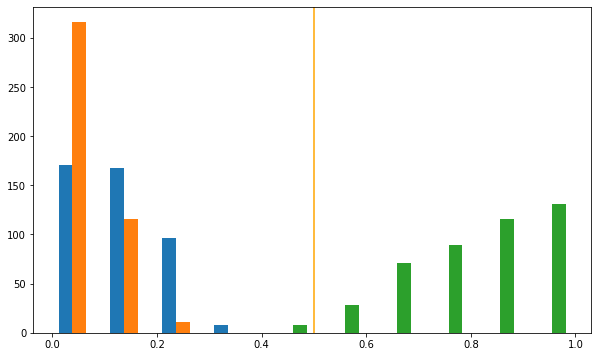

In [47]:
y_hat = model.predict_proba(xtest)
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

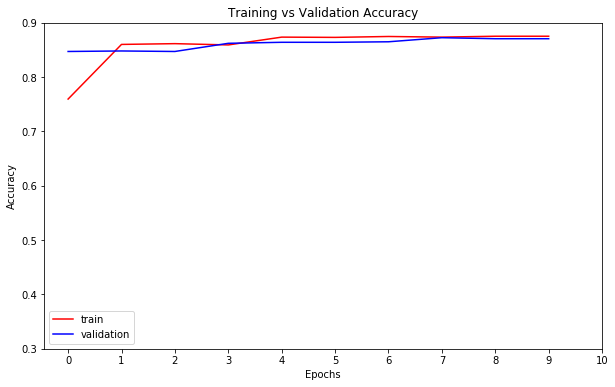

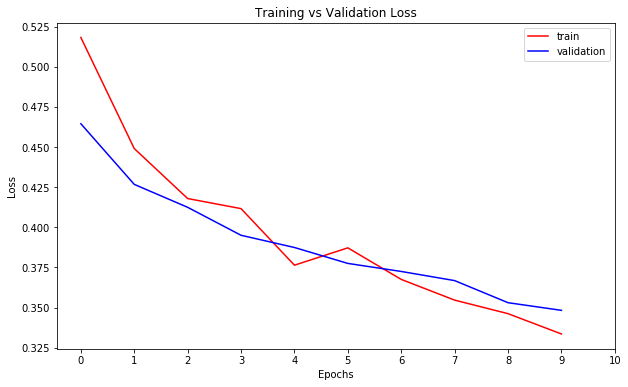

In [48]:
plt.plot(history.history['acc'], color='red')
plt.plot(history.history['val_acc'], color='blue')
plt.xticks(np.arange(0, epoch + 1))
plt.yticks(np.arange(0.3, 1, 0.1))
plt.rcParams['figure.figsize'] = (10, 6)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend(['train','validation'])
plt.show()

plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='blue')
plt.xticks(np.arange(0, epoch + 1))
plt.rcParams['figure.figsize'] = (5, 3)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend(['train','validation'])
plt.show()